### Ian Gilman
### CBB 555 Problem Set 1
### 2 October 2017

Whether it be morphological, ecological, or molecular data, real world bioinformatic questions involve inherently high dimensional data. Exploring these data through clustering may be a preliminary step or the end goal of analyses such as data partitioning or species delimitation, respectively. Often, data clustering and visualization in high dimension is computationally taxing and difficult to interpret. Hence, many bioinformatic methods begin with dimensionality reduction through a variety of algorithms. In problem set 1 I experiment with two commonly employed techniques of dimentionality reduction, prinicipal component analysis (PCA) and diffusion maps. I begin with a simulated dataset of a swiss roll and compare the two methods using a variety of diffusion maps. I then apply a diffusion map to a subset of a mass cytometry dataset from [1] that shows cellular reprogramming of induced pluripotent stem cells (iPSCs). I find diffusion maps to better preserve high dimensional information in low dimensional space.

## Experiment 1: Swiss Roll Dataset

### 1.1 Visualization
Adapted from the project description,
    
>The “swiss roll” data set is a commonly used synthetic data set to test embedding algorithms. The swiss roll is a good test case because it consists of points sampled from a 2-dimensional manifold. Without getting overly technical, a set $X \subset \mathbb{R}^n$ is a 2-dimensional manifold if at every point $x \in X$, a neighborhood around $x$ looks just like a section of $\mathbb{R}^2$. Geometrically, you can think about this as a 2 dimensional sheet in 3 dimensional space (or higher). Because the swiss roll has this kind of structure, it’s easy for us to understand what a “good” 2 dimensional embedding looks like.

In [3]:
import numpy as np
import codecs, json
# import ps1_functions as psf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

First we'll import the data using the skeleton functions and center it using the mean vector.

In [4]:
def load_json_files(file_path):
    '''
    Loads data from a json file

    Inputs:
        file_path   the path of the .json file that you want to read in

    Outputs:
        my_array    this is a numpy array if data is numeric, it's a list if it's a string

    '''

    #  load data from json file
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    b_new = json.loads(obj_text)

    # if a string, then returns list of strings
    if type(b_new[0]) is unicode:
        my_array = [b.encode('ascii','ignore') for b in b_new]  # translate from unicode to ascii

    # otherwise, it's assumed to be numeric and returns numpy array
    else:
        my_array = np.array(b_new)

    return my_array

In [6]:
sw_labels = load_json_files('data/swiss_roll_labels.json')
sw_points = load_json_files('data/swiss_roll_points.json')
mu = [np.ndarray.mean(sw_points[:,i]) for i in range(3)]
centered = np.transpose([(sw_points[:,i]-mu[i]) for i in range(3)])

Now we can visualize it.

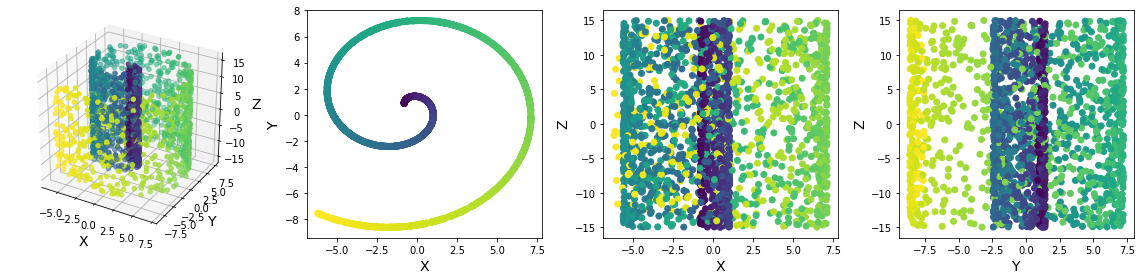

In [7]:
xs = centered[:,0]
ys = centered[:,1]
zs = centered[:,2]

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 4, 1, projection='3d')

ax.scatter(xs, ys, zs, c=sw_labels)
ax.set_xlabel('X', size='14')
ax.set_ylabel('Y', size='14')
ax.set_zlabel('Z', size='14')

################
ax = fig.add_subplot(1, 4, 2)
ax.scatter(xs, ys, c=sw_labels)
ax.set_xlabel('X', size='14')
ax.set_ylabel('Y', size='14')

################
ax = fig.add_subplot(1, 4, 3)
ax.scatter(xs, zs, c=sw_labels)
ax.set_xlabel('X', size='14')
ax.set_ylabel('Z', size='14')

################
ax = fig.add_subplot(1, 4, 4)
ax.scatter(ys, zs, c=sw_labels)
ax.set_xlabel('Y', size='14')
ax.set_ylabel('Z', size='14')

plt.tight_layout()

**Question 1.** What does this visualization of the swiss roll data set look like? What properties do you notice about the data set? Are the provided labels meaningful, and if so, in what way? How do you expect a “good” dimensionality reduction technique to look for the swiss roll data set?



Visualizing the swiss roll shows us, as the name suggests, that these are highly nonlinear data. The most telling feature of the data is the spiral seen from the project onto the X-Y plane, which also shows us that the labels refer to the location along the spiral. To reduce the dimentionality of these data we'll need a technique that can identify nonlinear features.

### 1.2 Initial Comparison of PCA and Diffusion Maps
#### 1.2.1 PCA

To conduct PCA I started out by finding the eigenvalues and eigenvectors of the covariance matrix. After going through the project, I found the results much more interpretable when the spread of the data along the z-axis was reduced such that there was relatively similar variation about each axis. The results are qualitatively the same but the diffusion maps behave a bit better.

In [8]:
centered[:,2] *= 0.5 # Reduce z-spread
cov = np.cov([centered[i,:] for i in range(3)])
e_val, e_vec = np.linalg.eig(cov)

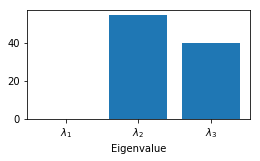

In [9]:
fig, ax = plt.subplots(figsize=(4,2))
ax.bar(left = range(3), height = e_val, label='Eigenvalue')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['$\lambda_1$','$\lambda_2$','$\lambda_3$'])
ax.set_xlabel('Eigenvalue')

We can see that the second two eigenvectors are much larger than the first. We'll make three mappings (`map1`, `map2`, and `map3`) that use the three possible combinations of eigenvectors and plot them below from most to least explained variance.

In [10]:
map1 = np.hstack([e_vec[:,1].reshape(3,1), e_vec[:,2].reshape(3,1)])
map2 = np.hstack([e_vec[:,1].reshape(3,1), e_vec[:,0].reshape(3,1)])
map3 = np.hstack([e_vec[:,2].reshape(3,1), e_vec[:,0].reshape(3,1)])
proj1 = map1.T.dot(centered.T)
proj2 = map2.T.dot(centered.T)
proj3 = map3.T.dot(centered.T)

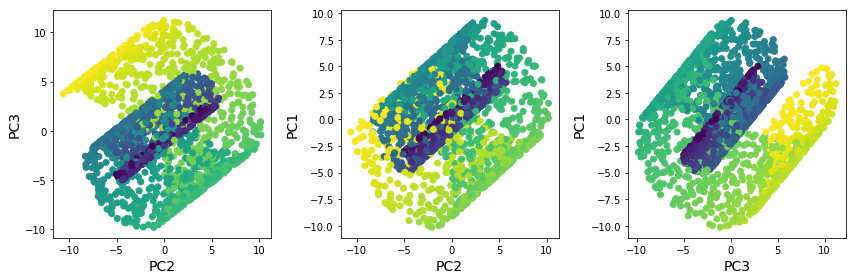

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].scatter(x=proj1[0,:], y=proj1[1,:], c=sw_labels)
ax[0].set_xlabel('PC2', size=14)
ax[0].set_ylabel('PC3', size=14)

ax[1].scatter(x=proj2[0,:], y=proj2[1,:], c=sw_labels)
ax[1].set_xlabel('PC2', size=14)
ax[1].set_ylabel('PC1', size=14)

ax[2].scatter(x=proj3[0,:], y=proj3[1,:], c=sw_labels)
ax[2].set_xlabel('PC3', size=14)
ax[2].set_ylabel('PC1', size=14)

plt.tight_layout()

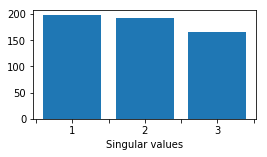

In [12]:
u, s, v = np.linalg.svd(centered)
fig, ax = plt.subplots(figsize=(4,2))
ax.bar(left = range(len(s)), height = s)
ax.set_xticklabels(['One', '','1','','2','','3'])
ax.set_xlabel('Singular values')

**Question 2.** As a dimensionality reduction technique, to what extent does PCA retain properties of the swiss roll data set? Can you explain why the visualizations look like this, given how the algorithm works? What can you learn about the intrinsic dimensionality from the singular values?

PCA has done little to transform our data along any set of components. Given that I am trying to find a new basis that is a _linear_ combination of our original basis, there was little hope that PCA would reduced the dimentionality in a meaningful way. The relatively similar sizes of the singular values suggest that our data is intrinsically three dimensional.

#### 1.2.1 Diffusion maps

To construct my diffusion maps I'll first build the machinery, in the form of functions, that will use the original data matrix to i) compute a distance matrix (`compute_distances`), ii) transform those distances to affinities (`compute_affinity_matrix`), iii) extract the information from the affinity matrix for the diffusion map (`diff_map_info`), and iv) erect a diffusion map from the affinity matrix (`get_diff_map`). Affinity matrices are constructed using a Gaussian kernel with either a fixed width or adaptive kernel. The adaptive kernel adapts the kernel width, $\sigma$, to the distance of the $k$-th nearest neighbor.

In [13]:
def compute_distances(X):
    '''
    Constructs a distance matrix from data set, assumes Euclidean distance

    Inputs:
        X   a numpy array of size n x p holding the data set (n observations, p features)
    Outputs:
        D   a numpy array of size n x n containing the euclidean distances between points
    '''
    # return distance matrix
    return [[np.linalg.norm(i-j) for j in X] for i in X]

In [14]:
def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
    '''
    Construct an affinity matrix from a distance matrix via gaussian kernel.

    Inputs:
        D               a numpy array of size n x n containing the distances between points
        kernel_type     a string, either "gaussian" or "adaptive".
                            If kernel_type = "gaussian", then sigma must be a positive number
                            If kernel_type = "adaptive", then k must be a positive integer
        sigma           the non-adaptive gaussian kernel parameter
        k               the adaptive kernel parameter

    Outputs:
        W       a numpy array of size n x n that is the affinity matrix

    '''
    # Check if all affinity conditions are met
    if not ((kernel_type=='gaussian' and sigma>0) or \
            ((kernel_type=='adaptive' and type(k)==int and k>0))):
        print("Kernel must be of type 'gaussian' with sigma>0, or \
        'adaptive' with k a positive integer.")
        return    
    
    # Compute with Gaussian kernel
    elif kernel_type=='gaussian':
        W = np.exp(-np.square(distances)/(2*sigma**2))
        
    # Compute with adaptive kernel        
    elif kernel_type=='adaptive':
        W = np.zeros(shape=np.shape(D))
        
        for i in range(np.shape(D)[0]):
            sigma = np.sort(D[i])[k]
            W[i] = np.exp(-np.square(D[i])/(2*sigma**2))
        
    # return the affinity matrix
    return np.asarray(W)

The **lambda** function in `sort_eigs` was taken from [StackExchange](https://stackoverflow.com/questions/20183069/how-to-sort-multidimensional-array-by-column).

In [15]:
def sort_eigs(evals, evects, by='desc'):
    '''Sorts a list of eigenvalues and eigenvectors based on the magnitude of the eigenvalues.
    
    Parameters
    ----------
    evals: list of eigenvalues
    evects: list of corresponding eigenvectors
    by: ascending ('asc') or descending ('desc'). default is descending'''
    
    # Create (val, vect) pairs
    zipped_eigs = zip(evals, evects)
    # Sort either ascending or descending
    if by=='desc':
        sorted_eigs = sorted(zipped_eigs,key=lambda x: -abs(x[0]))
        
    elif by=='asc':
        sorted_eigs = sorted(zipped_eigs,key=lambda x: abs(x[0]))
    else:
        print("'by' must be either 'desc' or 'asc'")
        return
        
    
    # Separate vals and vects into original formats
    sorted_evals = np.asarray([sorted_eigs[i][0] for i in range(len(sorted_eigs))])
    sorted_evects = np.asanyarray([sorted_eigs[i][1] for i in range(len(sorted_eigs))])
    
    return sorted_evals, sorted_evects

In [16]:
def diff_map_info(W):
    '''
    Construct the information necessary to easily construct diffusion map for any t

    Inputs:
        W           a numpy array of size n x n containing the affinities between points

    Outputs:

        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial 
            eigenvectors of Markov matrix as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial 
            eigenvalues of Markov matrix

        We assume the convention that the coordinates in the diffusion vectors 
            are in descending order
        according to eigenvalues.
    '''
    # Translate to ndarray and normalize to get Markov matrix
    markov = np.asarray(W)
    markov /= W.sum(axis=1)[:,None]
    
    # Get eigen pairs (real parts)
    mvals, mvects = np.linalg.eig(markov)
    mvals = np.real(mvals)
    mvects = np.real(mvects)
    
    # Sort eigenvalues and select nontrival
    sorted_mvals, sorted_mvects = sort_eigs(evals=mvals, evects=mvects, by= 'desc')
    nontriv = len([eigval for eigval in mvals if eigval<1])
    diff_eig = sorted_mvals[1:]
    diff_vec = np.asarray(sorted_mvects)[:,1:]
    
    # return the info for diffusion maps
    return diff_vec, diff_eig

In [17]:
def get_diff_map(diff_vec, diff_eig, t):
    '''
    Construct a diffusion map at t from eigenvalues and eigenvectors of Markov matrix

    Inputs:
        diff_vec    a numpy array of size n x n-1 containing the n-1 nontrivial 
            eigenvectors of Markov matrix as columns
        diff_eig    a numpy array of size n-1 containing the n-1 nontrivial 
            eigenvalues of Markov matrix
        t           diffusion time parameter t

    Outputs:
        diff_map    a numpy array of size n x n-1, the diffusion map defined for t
    '''
    diff_map = np.asarray(diff_eig**t)*diff_vec
    return diff_map

##### 1.2.2.1 Using a width Gaussian kernel

Now I'll put all of the pieces together, beginning with the construction of the distance matrix and ending with the diffusion map using a Gaussian kernel (fixed width $\sigma \in \{1.0, 3.0, 6.0\}$) and diffusion parameter $t=1$.

In [18]:
distances = compute_distances(centered)
g1 = compute_affinity_matrix(distances, kernel_type='gaussian', sigma=1.0)
g3 = compute_affinity_matrix(distances, kernel_type='gaussian', sigma=3.0)
g6 = compute_affinity_matrix(distances, kernel_type='gaussian', sigma=6.0)
g1_vects, g1_vals = diff_map_info(g1)
g3_vects, g3_vals = diff_map_info(g3)
g6_vects, g6_vals = diff_map_info(g6)

In [21]:
distances[:3]

[[0.0,
  8.1929754631828082,
  5.5689342290820125,
  10.616618766533428,
  8.0300434411057857,
  11.630402844857405,
  7.8366194295454283,
  14.139844591177223,
  7.3677604922004223,
  16.355199601968266,
  5.6879040132143945,
  1.4700371915292538,
  5.8051516080986785,
  12.270946171541155,
  14.323696109841194,
  9.5332476095268142,
  13.641548240489508,
  9.1164644225412115,
  4.3988099921971191,
  8.6365115187317958,
  8.0966766762357523,
  14.42980326835918,
  5.9255479797051134,
  8.8001697368253229,
  12.50737156686529,
  13.425686939955096,
  7.615934171408882,
  8.6894831456873263,
  10.458462745224804,
  16.040768176301722,
  14.372191004009519,
  10.236396568812713,
  8.2915210416021825,
  7.6606013731013771,
  7.9562845058754919,
  10.450791566721836,
  13.921260418563692,
  11.788477816876322,
  13.668829302660527,
  7.4134171599295797,
  13.410191051308711,
  14.813139599842605,
  12.863615087029894,
  4.6836209032117413,
  8.0898964738240586,
  12.267438132889588,
  5.41

We'll plot the eigenvectors of each diffusion map to compare kernel widths.

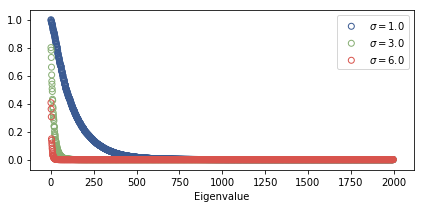

In [15]:
fig, ax = plt.subplots(figsize=(6,3))

ax.scatter(x=range(len(g1_vals)), y=g1_vals, marker='o', facecolors='none', \
           edgecolors='xkcd:denim blue', label='$\sigma=1.0$')
ax.scatter(x=range(len(g3_vals)), y=g3_vals, marker='o', facecolors='none', \
           edgecolors='xkcd:sage', label='$\sigma=3.0$')
ax.scatter(x=range(len(g6_vals)), y=g6_vals, marker='o', facecolors='none', \
           edgecolors='xkcd:pale red', label='$\sigma=6.0$')

ax.set_xlabel('Eigenvalue')
plt.legend(loc='upper right')
plt.tight_layout()

In [16]:
g1_dmap = get_diff_map(g1_vects, g1_vals, t=1)
g3_dmap = get_diff_map(g3_vects, g3_vals, t=1)
g6_dmap = get_diff_map(g6_vects, g6_vals, t=1)

With each diffusion map we can plot a subset of the diffusion axes.

In [17]:
def plot_32diff_maps(diffmap, title, colors=sw_labels, cmap=None, sharex=True, sharey=True):
    '''Constructs a plot of the nine combinations of diffusion components specified in plot 
    3.2 in the project description.
    
    Parameters:
    -----------
    diffmap: a diffusion map
    title: matplotlib style title
    colors: matplotlib style tuple of colors (default is sw_labels)
    cmap: maplotlib stlye colormap (default is None)
    sharex: subplots share same x axis (default is True)
    sharey: subplots share same y axis (default is True)
    '''
    fig, ax = plt.subplots(3, 3, figsize=(9,9), sharex=sharex, sharey=sharey)

    ax[0,0].scatter(x=diffmap[:,0], y=diffmap[:,1], c=colors, alpha=0.5, cmap=cmap)
    ax[0,0].set_xlabel('DM 1')
    ax[0,0].set_ylabel('DM 2')
    ax[0,1].scatter(x=diffmap[:,0], y=diffmap[:,2], c=colors, alpha=0.5, cmap=cmap)
    ax[0,1].set_xlabel('DM 1')
    ax[0,1].set_ylabel('DM 3')
    ax[0,2].scatter(x=diffmap[:,1], y=diffmap[:,2], c=colors, alpha=0.5, cmap=cmap)
    ax[0,2].set_xlabel('DM 2')
    ax[0,2].set_ylabel('DM 3')

    ax[1,0].scatter(x=diffmap[:,1], y=diffmap[:,3], c=colors, alpha=0.5, cmap=cmap)
    ax[1,0].set_xlabel('DM 2')
    ax[1,0].set_ylabel('DM 4')
    ax[1,1].scatter(x=diffmap[:,2], y=diffmap[:,3], c=colors, alpha=0.5, cmap=cmap)
    ax[1,1].set_xlabel('DM 3')
    ax[1,1].set_ylabel('DM 4')
    ax[1,2].scatter(x=diffmap[:,2], y=diffmap[:,4], c=colors, alpha=0.5, cmap=cmap)
    ax[1,2].set_xlabel('DM 3')
    ax[1,2].set_ylabel('DM 5')

    ax[2,0].scatter(x=diffmap[:,3], y=diffmap[:,4], c=colors, alpha=0.5, cmap=cmap)
    ax[2,0].set_xlabel('DM 4')
    ax[2,0].set_ylabel('DM 5')
    ax[2,1].scatter(x=diffmap[:,3], y=diffmap[:,5], c=colors, alpha=0.5, cmap=cmap)
    ax[2,1].set_xlabel('DM 4')
    ax[2,1].set_ylabel('DM 6')
    ax[2,2].scatter(x=diffmap[:,4], y=diffmap[:,5], c=colors, alpha=0.5, cmap=cmap)
    ax[2,2].set_xlabel('DM 5')
    ax[2,2].set_ylabel('DM 6')

    plt.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()

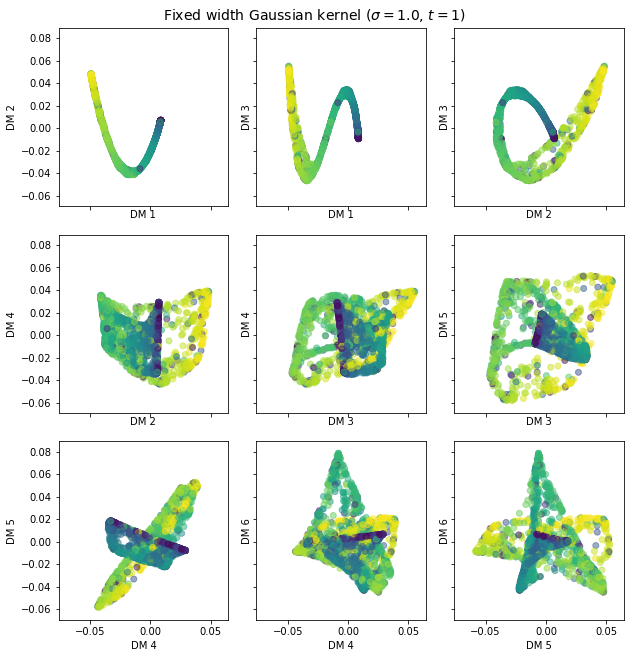

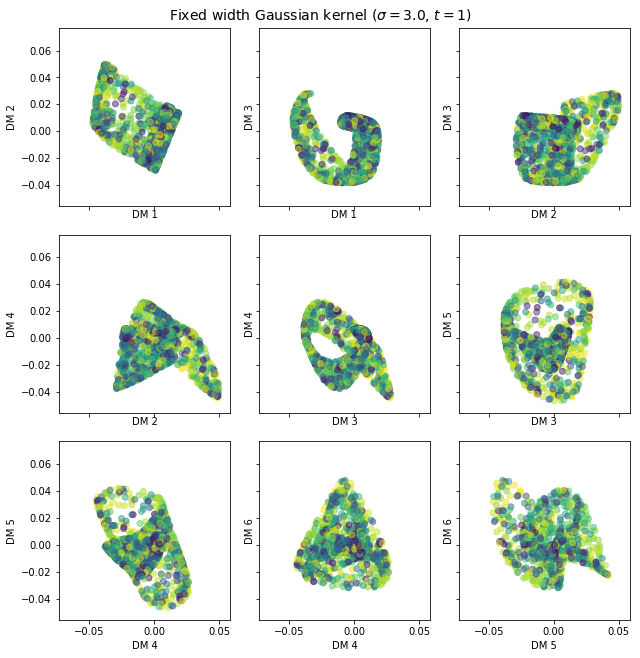

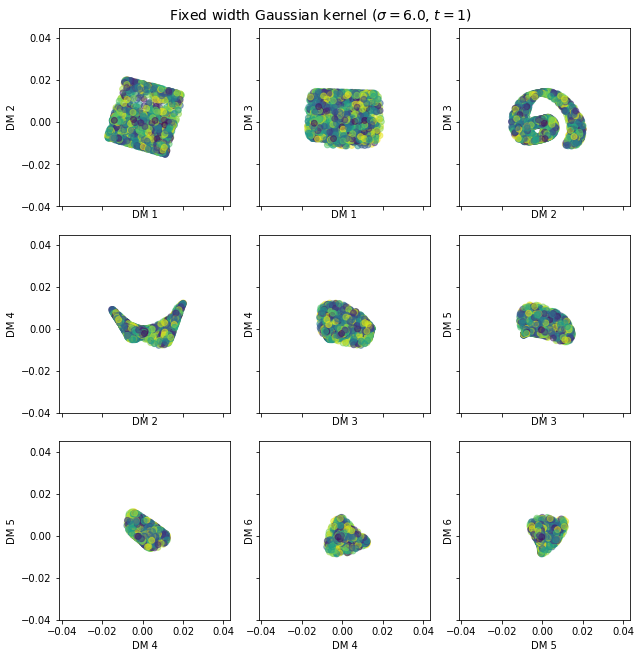

In [18]:
plot_32diff_maps(g1_dmap, title='Fixed width Gaussian kernel ($\sigma=1.0$, $t=1$)')
plot_32diff_maps(g3_dmap, title='Fixed width Gaussian kernel ($\sigma=3.0$, $t=1$)')
plot_32diff_maps(g6_dmap, title='Fixed width Gaussian kernel ($\sigma=6.0$, $t=1$)')

**Question 3.** As a dimensionality reduction technique, to what extent does diffusion mapping retain properties of the swiss roll data set? Can you explain why the visualizations look like this, given how the algorithm works? What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of $M$? How does the choice of Gaussian kernel width $\sigma$ change the embedding and why?

Diffusion mapping retains the closeness of the data across larger scales than PCA. By this, I mean that there are relatively smooth transitions from "yellow" to "green" to "darker green"/"blue" points in the diffusion maps that are not observed in PCA. However, points close together cluster more tightly in the PCA above; that is, distinct color banding is evident but "blue" points lay inbetween "yellow" and "green" points, therefore large-scale distances are not preserved well. Clusters are more readily observed with smaller kernel widths, which may be the result of connecting points "across" the swiss roll with large values of $\sigma$. Because there is a greater range in z-axis values for any given "color" of points, there will be many pairs of points of different color that have smaller distances than those of the same color, which will hamper diffusion through the spiral. To test this, I multipled all z values by $1/2$ (see above), therefore halving their standard deviation, and found much more obvious clustering among the colors for a wider range of embeddings.  

The decay spectrum of the eigenvalues corresponds to the number of well-defined clusters found in the data. Eigenvalues close to one represent large-scale patterns, and we see that the number of eigenvalues near one rapidly falls off as $\sigma$ increases. This is due to the increased diffusion "across" layers of the swiss roll when our kernel width increases. 

Now we can use the distance matrix and the largest eigenvect of our affinity matrix to find the largest left eigenvector, $\phi_1$, of the Markov matrix.

In [19]:
g1 = compute_affinity_matrix(D=distances, kernel_type='gaussian', sigma=1.0)
g1_Dhalf = np.sqrt(np.identity(len(np.sum(g1, axis=1)))*np.sum(g1, axis=1))
g1_phi1 = g1_vects[:,0].dot(g1_Dhalf)

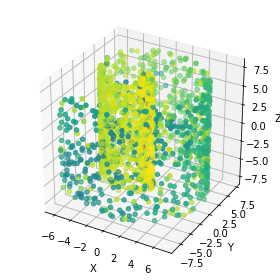

In [20]:
xs = centered[:,0]
ys = centered[:,1]
zs = centered[:,2]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=g1_phi1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()

**Question 4.** How do the values in $\phi_1$ correspond to the structure of the swiss roll? Can you explain what you are seeing in terms of diffusion?

Nadler et al. (2005) note that $\phi_1$ corresponds to a density estimate at $\boldsymbol{x}$. We see that the darker blue hues are the least dense areas and that the color shifts towards yellow where density is at its highest (at the center of the spiral). This pattern was much less evident before the standard deviation in the z-axis was halved.

##### 1.2.2.2 Using an adaptive Gaussian kernel
I'll repeat the above analysis using an adaptive Gaussian kernel with either 5 or 10 neighbors.

In [21]:
a5 = compute_affinity_matrix(distances, kernel_type='adaptive', k=5)
a10 = compute_affinity_matrix(distances, kernel_type='adaptive', k=10)

a5_vects, a5_vals = diff_map_info(a5)
a10_vects, a10_vals = diff_map_info(a10)

a5_dmap = get_diff_map(a5_vects, a5_vals, t=1)
a10_dmap = get_diff_map(a10_vects, a10_vals, t=1)

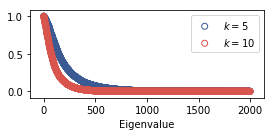

In [22]:
fig, ax = plt.subplots(figsize=(4,2))

ax.scatter(x=range(len(a5_vals)), y=a5_vals, marker='o', facecolors='none', \
           edgecolors='xkcd:denim blue', label='$k=5$')
ax.scatter(x=range(len(a10_vals)), y=a10_vals, marker='o', facecolors='none', \
           edgecolors='xkcd:pale red', label='$k=10$')

ax.set_xlabel('Eigenvalue')
plt.legend(loc='upper right')
plt.tight_layout()

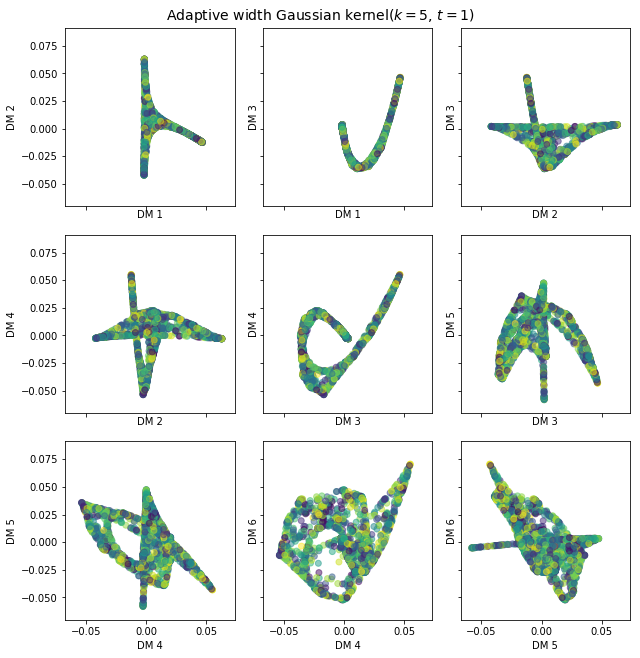

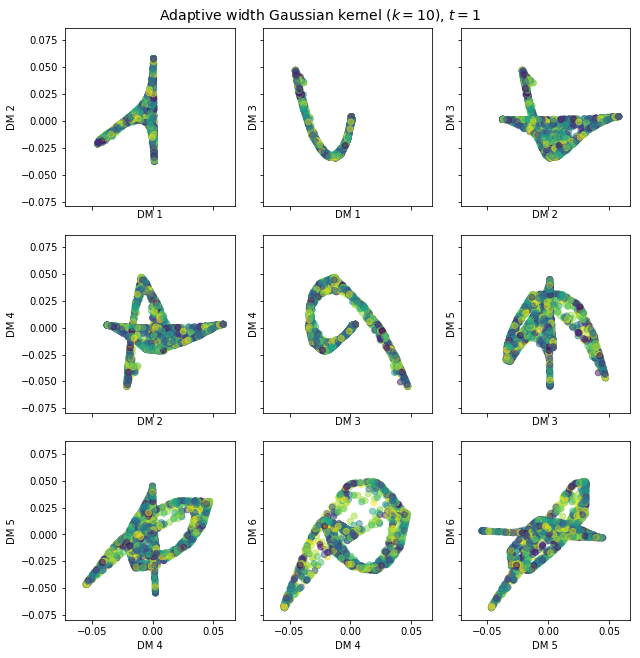

In [23]:
plot_32diff_maps(a5_dmap, title='Adaptive width Gaussian kernel($k=5$, $t=1$)')
plot_32diff_maps(a10_dmap, title='Adaptive width Gaussian kernel ($k=10$), $t=1$')

**Question 5.** What are the differences between fixed and adaptive choices of kernel parameters $\sigma$? Explain this difference. What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of $M$? How does the choice of nearest neighbor parameter $k$ change the diffusion map? Which kernel method would you recommend using for the swiss roll data set and why?

The difference between fixed and adaptive kernels is that the latter incorporate local estimates of density when claculating the affinity between points. The density information comes from the distance the points of interest are to their respective neighbors, and thus is controlled by $k$, the number of neighbors to consider. The eigenvalues of $M$ show a similar pattern to those of the fixed width Gaussian kernel with $\sigma=1$, suggesting that there may be several large-scale patterns in the data. However, there was much less clustering by color using either value of $k$ with an adaptive kernel. The choice of $k$ produced no readily observable patterns in the data once they were projected into diffusion space. Further testing of $k=3$ and $k=20$ yielded no further insight into the influence of $k$ on clustering. My initial hypothesis was that there would be a range of ideal $k$ values that capture the variation of points along the swiss roll without jumping between layers. This was not observed, and so I reccomend using a width width kernel for analyzing the swiss roll data.

### 1.3 Changing the diffusion parameter, $t$
Using an adaptive kernel with $k=10$, we'll examine the effect of increasing the diffusion parameter. Because my best results came from a fixed width kernel ($\sigma=1.0$) I repeated the analysis with these parameters.

In [24]:
a10_t10_dmap = get_diff_map(a5_vects, a5_vals, t=10)
g1_t10_dmap = get_diff_map(g1_vects, g1_vals, t=100)

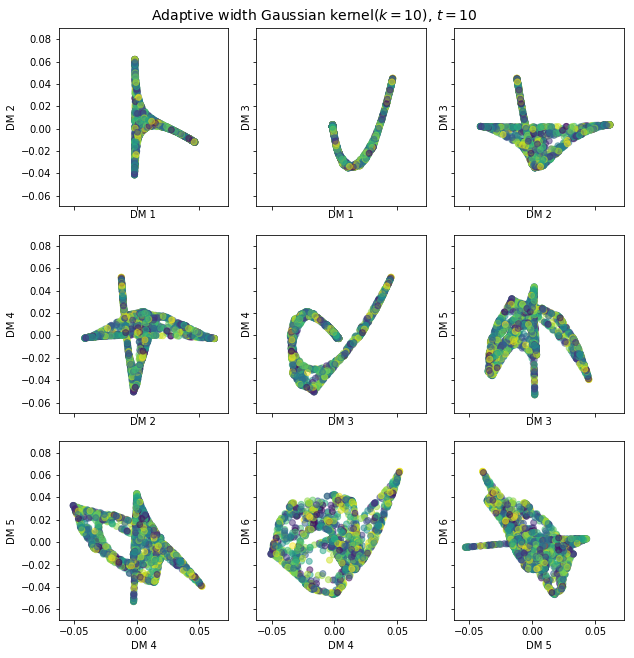

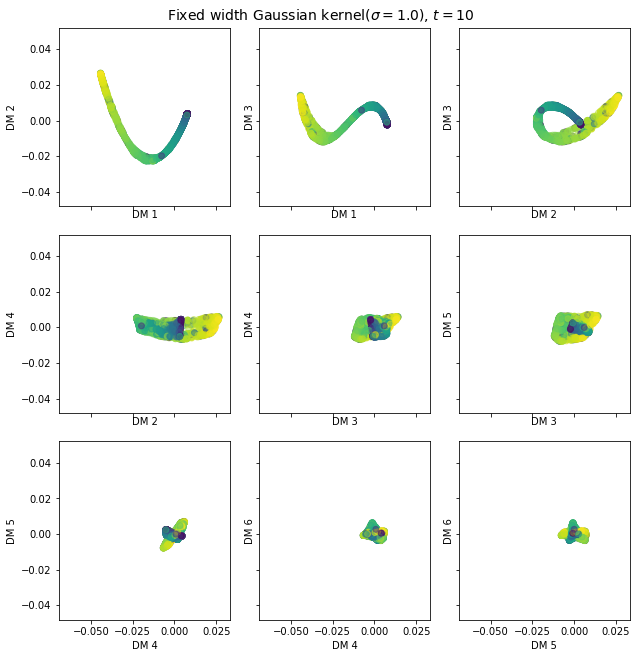

In [25]:
plot_32diff_maps(a10_t10_dmap, title='Adaptive width Gaussian kernel($k=10$), $t=10$')
plot_32diff_maps(g1_t10_dmap, title='Fixed width Gaussian kernel($\sigma=1.0$), $t=10$')

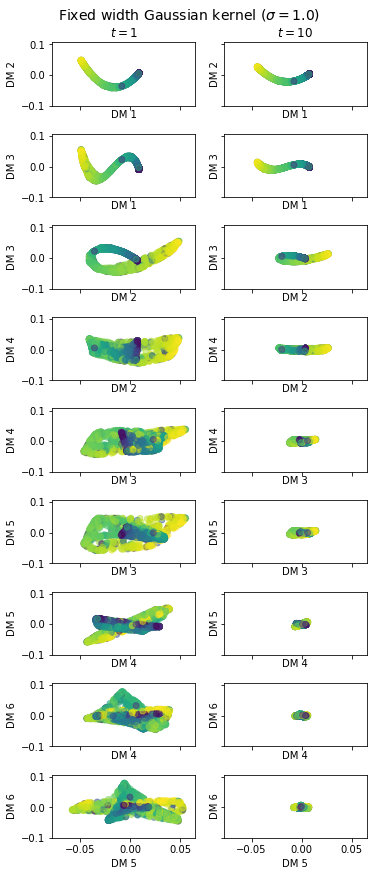

In [26]:
fig, ax = plt.subplots(9, 2, figsize=(5.34,12), sharex=True, sharey=True)

ax[0,0].scatter(x=g1_dmap[:,0], y=g1_dmap[:,1], c=sw_labels, alpha=0.5, cmap=None)
ax[0,0].set_xlabel('DM 1')
ax[0,0].set_ylabel('DM 2')
ax[0,0].set_title('$t=1$')
ax[0,1].scatter(x=g1_t10_dmap[:,0], y=g1_t10_dmap[:,1], c=sw_labels, alpha=0.5)
ax[0,1].set_xlabel('DM 1')
ax[0,1].set_ylabel('DM 2')
ax[0,1].set_title('$t=10$')

ax[1,0].scatter(x=g1_dmap[:,0], y=g1_dmap[:,2], c=sw_labels, alpha=0.5)
ax[1,0].set_xlabel('DM 1')
ax[1,0].set_ylabel('DM 3')
ax[1,1].scatter(x=g1_t10_dmap[:,0], y=g1_t10_dmap[:,2], c=sw_labels, alpha=0.5)
ax[1,1].set_xlabel('DM 1')
ax[1,1].set_ylabel('DM 3')

ax[2,0].scatter(x=g1_dmap[:,1], y=g1_dmap[:,2], c=sw_labels, alpha=0.5)
ax[2,0].set_xlabel('DM 2')
ax[2,0].set_ylabel('DM 3')
ax[2,1].scatter(x=g1_t10_dmap[:,1], y=g1_t10_dmap[:,2], c=sw_labels, alpha=0.5)
ax[2,1].set_xlabel('DM 2')
ax[2,1].set_ylabel('DM 3')

ax[3,0].scatter(x=g1_dmap[:,1], y=g1_dmap[:,3], c=sw_labels, alpha=0.5)
ax[3,0].set_xlabel('DM 2')
ax[3,0].set_ylabel('DM 4')
ax[3,1].scatter(x=g1_t10_dmap[:,1], y=g1_t10_dmap[:,3], c=sw_labels, alpha=0.5)
ax[3,1].set_xlabel('DM 2')
ax[3,1].set_ylabel('DM 4')

ax[4,0].scatter(x=g1_dmap[:,2], y=g1_dmap[:,3], c=sw_labels, alpha=0.5)
ax[4,0].set_xlabel('DM 3')
ax[4,0].set_ylabel('DM 4')
ax[4,1].scatter(x=g1_t10_dmap[:,2], y=g1_t10_dmap[:,3], c=sw_labels, alpha=0.5)
ax[4,1].set_xlabel('DM 3')
ax[4,1].set_ylabel('DM 4')

ax[5,0].scatter(x=g1_dmap[:,2], y=g1_dmap[:,4], c=sw_labels, alpha=0.5)
ax[5,0].set_xlabel('DM 3')
ax[5,0].set_ylabel('DM 5')
ax[5,1].scatter(x=g1_t10_dmap[:,2], y=g1_t10_dmap[:,4], c=sw_labels, alpha=0.5)
ax[5,1].set_xlabel('DM 3')
ax[5,1].set_ylabel('DM 5')

ax[6,0].scatter(x=g1_dmap[:,3], y=g1_dmap[:,4], c=sw_labels, alpha=0.5)
ax[6,0].set_xlabel('DM 4')
ax[6,0].set_ylabel('DM 5')
ax[6,1].scatter(x=g1_t10_dmap[:,3], y=g1_t10_dmap[:,4], c=sw_labels, alpha=0.5)
ax[6,1].set_xlabel('DM 4')
ax[6,1].set_ylabel('DM 5')

ax[7,0].scatter(x=g1_dmap[:,3], y=g1_dmap[:,5], c=sw_labels, alpha=0.5)
ax[7,0].set_xlabel('DM 4')
ax[7,0].set_ylabel('DM 6')
ax[7,1].scatter(x=g1_t10_dmap[:,3], y=g1_t10_dmap[:,5], c=sw_labels, alpha=0.5)
ax[7,1].set_xlabel('DM 4')
ax[7,1].set_ylabel('DM 6')

ax[8,0].scatter(x=g1_dmap[:,4], y=g1_dmap[:,5], c=sw_labels, alpha=0.5)
ax[8,0].set_xlabel('DM 5')
ax[8,0].set_ylabel('DM 6')
ax[8,1].scatter(x=g1_t10_dmap[:,4], y=g1_t10_dmap[:,5], c=sw_labels, alpha=0.5)
ax[8,1].set_xlabel('DM 5')
ax[8,1].set_ylabel('DM 6')

plt.suptitle('Fixed width Gaussian kernel ($\sigma=1.0$)', fontsize=14, y=1.01)
plt.tight_layout()

Directly comparing pairs of embeddings at different times shows that the spread in the data has dramatically decreased but the overall patterns of clustering are preserved.

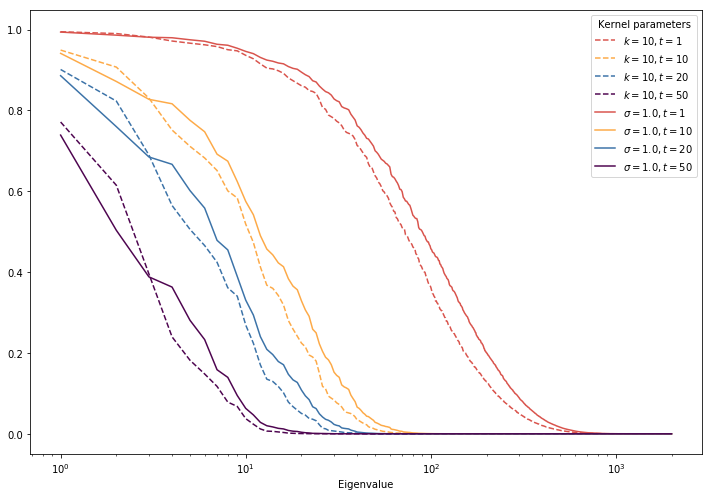

In [27]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(range(len(a10_vals)), a10_vals,'--', color='xkcd:pale red', label='$k=10, t=1$')
ax.plot(range(len(a10_vals)), a10_vals**10, '--', color='xkcd:light orange', label='$k=10, t=10$')
ax.plot(range(len(a10_vals)), a10_vals**20, '--', color='xkcd:flat blue', label='$k=10, t=20$')
ax.plot(range(len(a10_vals)), a10_vals**50, '--', color='xkcd:plum purple', label='$k=10, t=50$')

ax.plot(range(len(g1_vals)), g1_vals,'-', color='xkcd:pale red', label='$\sigma=1.0, t=1$')
ax.plot(range(len(g1_vals)), g1_vals**10, '-', color='xkcd:light orange', label='$\sigma=1.0, t=10$')
ax.plot(range(len(g1_vals)), g1_vals**20, '-', color='xkcd:flat blue', label='$\sigma=1.0, t=20$')
ax.plot(range(len(g1_vals)), g1_vals**50, '-', color='xkcd:plum purple', label='$\sigma=1.0, t=50$')

ax.set_xlabel('Eigenvalue')
plt.semilogx()
plt.legend(loc='upper right', title='Kernel parameters')
plt.tight_layout()

**Question 6.** In terms of diffusion processes, what is the interpretation of increasing $t$? How do the diffusion embeddings visually change as $t$ increases? How do the eigenvalues change and how does this help explain what you see in the embeddings? What can you learn about the intrinsic dimensionality of the data set from the eigenvalues of $M$ as $t$ increases? Is there a specific value of $t$ that you find most informative for the Swiss roll data set?

As noted by Nadler et al. [2], increasing $t$ decreases the neigborhood of points examined, therefore increasing the probability of a particular subset of diffusion paths. This had the effect of lowering the spread of the data in the embeddings. As $t$ increases, the eigenvalues decrease more and more rapidly, which indicates that there are less large scale patterns in the embedding. If this decay had occured more slowly, it may be evidence of high dimensionality in the data, hence more conspicuous patterns among those dimensions. All values of $t$ above one produced embeddings with less clear clustering. This was also counter to my original hypothesis that our kernel widths were too large, and therefore evolution of the diffusion map would improve the clustering within the embeddings.

**Question 7.** Suppose your boss is very delighted by your implementation of diffusion mappings and the initial tests on the swiss roll dataset; however, she would like to see how the method works on other artificial “control” data sets. Describe two other data sets that you might generate and what you would expect to see from these tests. You do not need to construct these two data sets.

Two insightful datasets would be one that shows the limits of diffusion maps, such as a uniform or random distribution of points, and another that shows the efficiency in detecting non-linear patterns in high dimensional space, such as a sine (or cosine) wave in many dimensions. The purpose of the uniform or random distribution would be to demonstate that diffusion maps have a low false positive rate; that is, they will not pick up on signal in the data if there is none. The second is an excellent example of data with multiple patterns that would not be able to teased apart with linear methods, and would also show an application of diffusion maps to oscillations, a ubiquitous pattern in nature.

## Experiment 2: iPSC Reprogramming Dataset

Adapted from the project description,

>This is a mass cytometry dataset taken from [1] that shows cellular reprogramming from mouse embryonic fibroblasts (MEFs) to induced pluripotent stem cells (iPSCs) via the introduction of a transcription factor known as _Oct4_. This data set measures 33 proteins at the single-cell resolution. The protein markers measure
1. pluripotency or stem-ness, e.g. _sox4_, _oct4_
2. differentiation: e.g. _nanog_ and _lin28_ which are embryonic stem cell (ESC) markers
3. cell-cycle: e.g. _pRB_ which is a cell proliferation marker
4. signaling status: e.g. _pakt_ which is a growth inducing signal and _p53_ which signals DNA damage and could induce cell cycle arrest. The “p” preceding some of these markers indicates that the measurement is for the phosphorylated (usually active) conformation of the protein
5. apoptosis: e.g. _ccasp3_ which is a caspase marker involved in programmed cell death

>Additionally a “timepoint” marker shows the day after stimulation with reprograming factors that the measurement was taken from. Here you have a mix of timepoints. These are low-granularity time points (on the order of days), while the actual transition is much finer grained. These protein markers enable the measurement of the reprogramming status. For instance, a subset of cells shows evidence of being early reprogramming intermediates with the “correct” set of reprogramming factors _Sox2_+_Oct4_+_Klf4_+_Nanog_, another subset seems successfully reprogrammed with ESC-like lineages expressing markers such as _Nanog_, _Oct4_, _Lin28_, _Ssea1_, and _Epcam_ that are associated with transition to pluripotency.

### 2.1 Comparing PCA and Diffusion Maps


In [28]:
ipsc_points = psf.load_json_files('data/ipsc_data.json')
ipsc_channel_names = psf.load_json_files('data/ipsc_channel_names.json')

ipsc_mu = [np.ndarray.mean(ipsc_points[:,i]) for i in range(len(ipsc_points[0]))]
ipsc_centered = np.transpose([(ipsc_points[:,i]-ipsc_mu[i]) for i in range(len(ipsc_mu))])
ipsc_cov = np.cov([ipsc_centered[i,:] for i in range(len(ipsc_centered[i,:]))])
ipsc_eval, ipsc_evec = np.linalg.eig(ipsc_cov)

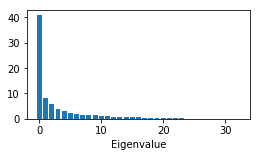

In [29]:
fig, ax = plt.subplots(figsize=(4,2))
ax.bar(left = range(len(ipsc_eval)), height = ipsc_eval)
ax.set_xlabel('Eigenvalue')

In [30]:
ipsc_map12 = np.hstack([ipsc_evec[:,0].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,1].reshape(len(ipsc_eval),1)])
ipsc_map13 = np.hstack([ipsc_evec[:,0].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,2].reshape(len(ipsc_eval),1)])
ipsc_map14 = np.hstack([ipsc_evec[:,0].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,3].reshape(len(ipsc_eval),1)])
ipsc_map15 = np.hstack([ipsc_evec[:,0].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,4].reshape(len(ipsc_eval),1)])
ipsc_map23 = np.hstack([ipsc_evec[:,1].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,2].reshape(len(ipsc_eval),1)])
ipsc_map24 = np.hstack([ipsc_evec[:,1].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,3].reshape(len(ipsc_eval),1)])
ipsc_map25 = np.hstack([ipsc_evec[:,1].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,4].reshape(len(ipsc_eval),1)])
ipsc_map34 = np.hstack([ipsc_evec[:,2].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,3].reshape(len(ipsc_eval),1)])
ipsc_map35 = np.hstack([ipsc_evec[:,2].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,4].reshape(len(ipsc_eval),1)])
ipsc_map45 = np.hstack([ipsc_evec[:,3].reshape(len(ipsc_eval),1), \
                        ipsc_evec[:,4].reshape(len(ipsc_eval),1)])

ipsc_proj12 = ipsc_map12.T.dot(ipsc_centered.T)
ipsc_proj13 = ipsc_map13.T.dot(ipsc_centered.T)
ipsc_proj14 = ipsc_map14.T.dot(ipsc_centered.T)
ipsc_proj15 = ipsc_map15.T.dot(ipsc_centered.T)
ipsc_proj23 = ipsc_map23.T.dot(ipsc_centered.T)
ipsc_proj24 = ipsc_map24.T.dot(ipsc_centered.T)
ipsc_proj25 = ipsc_map25.T.dot(ipsc_centered.T)
ipsc_proj34 = ipsc_map34.T.dot(ipsc_centered.T)
ipsc_proj35 = ipsc_map35.T.dot(ipsc_centered.T)
ipsc_proj45 = ipsc_map45.T.dot(ipsc_centered.T)

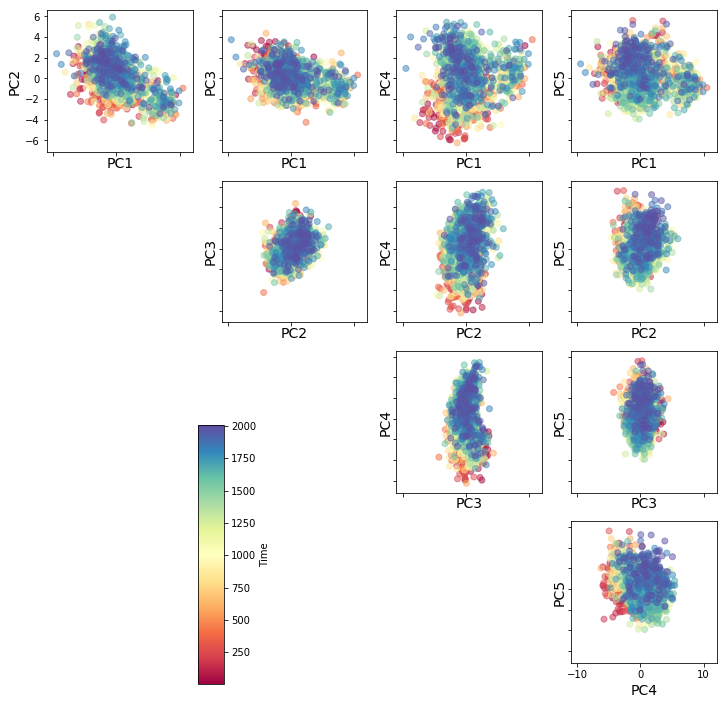

In [31]:
fig, ax = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True)
ax1 = fig.add_subplot(445)

ax[0,0].scatter(x=ipsc_proj12[0,:], y=ipsc_proj12[1,:],  marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[0,0].set_xlabel('PC1', size=14)
ax[0,0].set_ylabel('PC2', size=14)
ax[0,1].scatter(x=ipsc_proj13[0,:], y=ipsc_proj13[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[0,1].set_xlabel('PC1', size=14)
ax[0,1].set_ylabel('PC3', size=14)
ax[0,2].scatter(x=ipsc_proj14[0,:], y=ipsc_proj14[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[0,2].set_xlabel('PC1', size=14)
ax[0,2].set_ylabel('PC4', size=14)
ax[0,3].scatter(x=ipsc_proj15[0,:], y=ipsc_proj15[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[0,3].set_xlabel('PC1', size=14)
ax[0,3].set_ylabel('PC5', size=14)
ax[1,0].axis('off')
ax[1,1].scatter(x=ipsc_proj23[0,:], y=ipsc_proj23[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[1,1].set_xlabel('PC2', size=14)
ax[1,1].set_ylabel('PC3', size=14)
ax[1,2].scatter(x=ipsc_proj24[0,:], y=ipsc_proj24[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[1,2].set_xlabel('PC2', size=14)
ax[1,2].set_ylabel('PC4', size=14)
ax[1,3].scatter(x=ipsc_proj25[0,:], y=ipsc_proj25[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[1,3].set_xlabel('PC2', size=14)
ax[1,3].set_ylabel('PC5', size=14)
ax[2,0].axis('off')
ax[2,1].axis('off')
ax[2,2].scatter(x=ipsc_proj34[0,:], y=ipsc_proj34[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[2,2].set_xlabel('PC3', size=14)
ax[2,2].set_ylabel('PC4', size=14)
ax[2,3].scatter(x=ipsc_proj35[0,:], y=ipsc_proj35[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[2,3].set_xlabel('PC3', size=14)
ax[2,3].set_ylabel('PC5', size=14)
ax[3,0].axis('off')
ax[3,1].axis('off')
ax[3,2].axis('off')
ax[3,3].scatter(x=ipsc_proj45[0,:], y=ipsc_proj45[1,:], marker='o', facecolors='none', \
                alpha=0.5, c=range(1,2006), cmap=matplotlib.cm.Spectral)
ax[3,3].set_xlabel('PC4', size=14)
ax[3,3].set_ylabel('PC5', size=14)

cbaxes = fig.add_axes([0.3, 0.1, 0.03, 0.3]) 
normalize = matplotlib.colors.Normalize(vmin=1, vmax=2005)
scalarmappaple = matplotlib.cm.ScalarMappable(norm=normalize, cmap=matplotlib.cm.Spectral)
scalarmappaple.set_array(range(0,2005))
ax1.axis('off')

plt.colorbar(scalarmappaple, ax=ax1, cax=cbaxes, label='Time')

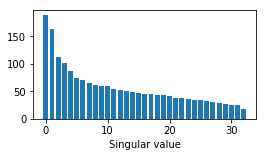

In [32]:
u, s, v = np.linalg.svd(ipsc_centered)
fig, ax = plt.subplots(figsize=(4,2))
ax.bar(left = range(len(s)), height = s)
ax.set_xlabel('Singular value')

In [33]:
print("The top three channels in PC1 are %s") % \
[ipsc_channel_names[i] for i in list(abs(ipsc_map12[:,0]).argsort()[-3:][::-1])]
print("The top three channels in PC2 are %s") % \
[ipsc_channel_names[i] for i in list(abs(ipsc_map12[:,1]).argsort()[-3:][::-1])]

The top three channels in PC1 are ['ox', 'pstat3-727', 'gfp']
The top three channels in PC2 are ['epcam', 'perk', 'h4kac']


**Question 8.** How do the PCA visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by PCA? What are the top few channels in the first and second principal directions?

The PCA fails to capture much time progress in the data or show any distinct clusters. In the projection along PC4 the there is a weak pattern corresponding to time. After the first PC, which is many times larger than the others, the next 8-10 are of comparable magnitude. This suggests that there may be a high dimensionality to the data. The top 3 channels for PC1 were _ox_, _pstat3-727_, and _gfp_, while the top 3 for PC2 were _epcam_, _perk_, and _h4kac_. Of these channels, _pstat3-727_ has function related to cell growth and apoptosis, and _perk_ is responsible for repression of global protein synthesis [3]. These functions are central to cell growth and differntiation.

Now I'll construct diffusion maps using an adaptive Gaussian kernel and three values of $k$.

In [34]:
ipsc_distances = compute_distances(ipsc_centered)

ipsc_k2 = compute_affinity_matrix(ipsc_distances, kernel_type='adaptive', k=2)
ipsc_k5 = compute_affinity_matrix(ipsc_distances, kernel_type='adaptive', k=5)
ipsc_k7 = compute_affinity_matrix(ipsc_distances, kernel_type='adaptive', k=7)

ipsc_k2_vects, ipsc_k2_vals = diff_map_info(ipsc_k2)
ipsc_k5_vects, ipsc_k5_vals = diff_map_info(ipsc_k5)
ipsc_k7_vects, ipsc_k7_vals = diff_map_info(ipsc_k7)

ipsc_k2_dmap = get_diff_map(ipsc_k2_vects, ipsc_k2_vals, t=1)
ipsc_k5_dmap = get_diff_map(ipsc_k5_vects, ipsc_k5_vals, t=1)
ipsc_k7_dmap = get_diff_map(ipsc_k7_vects, ipsc_k7_vals, t=1)

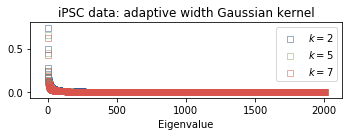

In [35]:
fig, ax = plt.subplots(figsize=(5,2))

ax.scatter(x=range(len(ipsc_k2_vals)), y=ipsc_k2_vals, marker='s', facecolors='none',\
           alpha=0.5, edgecolors='xkcd:denim blue', label='$k=2$')
ax.scatter(x=range(len(ipsc_k5_vals)), y=ipsc_k5_vals, marker='s', facecolors='none',\
           alpha=0.5, edgecolors='xkcd:sage', label='$k=5$')
ax.scatter(x=range(len(ipsc_k7_vals)), y=ipsc_k7_vals, marker='s', facecolors='none',\
           alpha=0.5, edgecolors='xkcd:pale red', label='$k=7$')

ax.set_xlabel('Eigenvalue')
plt.legend(loc='upper right')
plt.title('iPSC data: adaptive width Gaussian kernel')
plt.tight_layout()

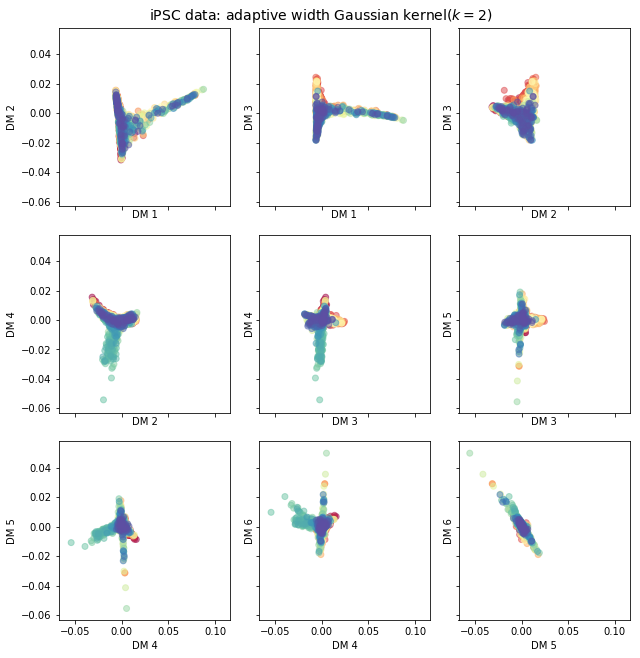

In [36]:
plot_32diff_maps(ipsc_k2_dmap, title='iPSC data: adaptive width Gaussian kernel($k=2$)', \
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral,)

The class `Vividict` came from [StackExchange](https://stackoverflow.com/questions/635483/what-is-the-best-way-to-implement-nested-dictionaries) and is used to create infinitely nestable dictionaries.

In [37]:
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

In [38]:
def diff_corr_plot(diffmap, title=None):
    '''Constructs a plot of the correlations between channels and a diffusion map 
    and the first three diffusion map components.
    
    Parameters:
    -----------
    diffmap: a diffusion map
    '''
    corrdict = Vividict()
    for comp in [0,1,2]:
        for channel in range(len(ipsc_channel_names)):
            corr = np.corrcoef(ipsc_centered[:,channel], diffmap[:,comp])[0,1]
            corrdict['DM'+str(comp+1)][ipsc_channel_names[channel]] = corr

    fig, ((ax1),(ax2), (ax3)) = plt.subplots(3,1, figsize=(8,6), sharex=True, sharey=True)

    ax1.bar(range(len(corrdict['DM1'])), corrdict['DM1'].values(), align='center')
    ax1.axhline(y=0.0, color='r', linestyle=':')
    ax1.axvspan(-0.5, 4.5, alpha=0.1, color='grey')
    ax1.axvspan(9.5, 14.5, alpha=0.1, color='grey')
    ax1.axvspan(19.5, 24.5, alpha=0.1, color='grey')
    ax1.axvspan(29.5, 34.5, alpha=0.1, color='grey')
    ax2.bar(range(len(corrdict['DM2'])), corrdict['DM2'].values(), align='center')
    ax2.axhline(y=0.0, color='r', linestyle=':')
    ax2.axvspan(-0.5, 4.5, alpha=0.1, color='grey')
    ax2.axvspan(9.5, 14.5, alpha=0.1, color='grey')
    ax2.axvspan(19.5, 24.5, alpha=0.1, color='grey')
    ax2.axvspan(29.5, 34.5, alpha=0.1, color='grey')
    ax3.bar(range(len(corrdict['DM3'])), corrdict['DM3'].values(), align='center')
    ax3.axhline(y=0.0, color='r', linestyle=':')
    ax3.axvspan(-0.5, 4.5, alpha=0.1, color='grey')
    ax3.axvspan(9.5, 14.5, alpha=0.1, color='grey')
    ax3.axvspan(19.5, 24.5, alpha=0.1, color='grey')
    ax3.axvspan(29.5, 34.5, alpha=0.1, color='grey')

    plt.xticks(range(len(corrdict['DM1'])), corrdict['DM1'].keys(), rotation='vertical')

    ax1.set_ylabel('DM1', size=14)
    ax2.set_ylabel('DM2', size=14)
    ax3.set_ylabel('DM3', size=14)
    plt.xlim([-.5,32.5])
    ax1.set_title(title, size=14)
    plt.tight_layout()

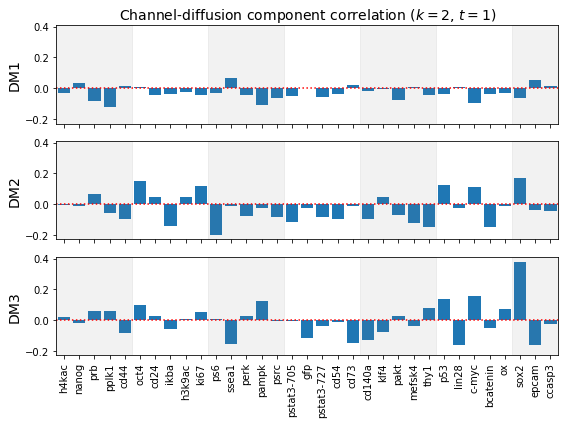

In [39]:
diff_corr_plot(ipsc_k2_dmap, title='Channel-diffusion component correlation ($k=2$, $t=1$)')

**Question 9.** How do the Diffusion Map visualizations look? Are they capturing the time progression of the data set? Do you see any clusters forming? What is the intrinsic dimensionality given by Diffusion Maps? Which channels are most highly correlated with diffusion components? Any guesses to the biological interpretation? What are the main differences between Diffusion Maps and PCA methods on the iPSC data set?

The diffusion maps primarily show differentiation between the later time points (~1,500-1,750), but there is little clustering between early and late time points. It is difficult to extract information regarding the intrinsic dimensionality of the data with the current parameter settings, but this may indicate high dimensionality that is difficult to visualize in a 2-dimensional embedding. We know there are 33 features in these data but only a few highly correlated with the first three diffusion components. The channels highest correlated with component one are _pplk1_, _pampk_, _c-myc_, _prb_, and _pakt_. Interestingly, all of these were negatively correlated with DM1, although weakly. Stronger correlations were observed between channels and component 2, with the highest correlated channels being _ps6_, _sox2_, _oct4_, _thy1_, and _bcatenin_; these were mixed positive and negative correlations.  The strongest correlations were found between channels and component three; these were _sox2_ (highest overall, 0.379), _epcam_, _lin28_, _c-myc_, and _ssea1_. 

Gene ontology from the project description and NCBI [3] states that 
* _sox2_ is involved in stem cell maintenance and the ultimate determination of cell fate
* _lin28_ is part of a larger gene family  involved in maturation of embryonic stem cells
* _c-myc_ has been linked to cell cycle progress
* _pplk1_ controls cell division and apoptosis
* _lin28_ is an ESC marker
* _prb_ is a cell proliferation marker

Taken together, the correlation of differential expression of stem cell maturation and cell cycle progression genes with our diffusion components indicates there may be measurable differences among time points due to stem cell differentiation. This differentiation is not immediately clear using a diffusion map with the above parameters, but the separation of late time points is greater using diffusion maps than PCA. I explore other parameter settings ($k=5,7$, $t=2, 3$) below in an attempt to better cluster the iPSC data among time points. Note that in the above plots that the axes limits are not fixed between subplots. Due to the collapsing of many points to a single points in diffusion space, I let the axes limits vary to show what spread there was. 

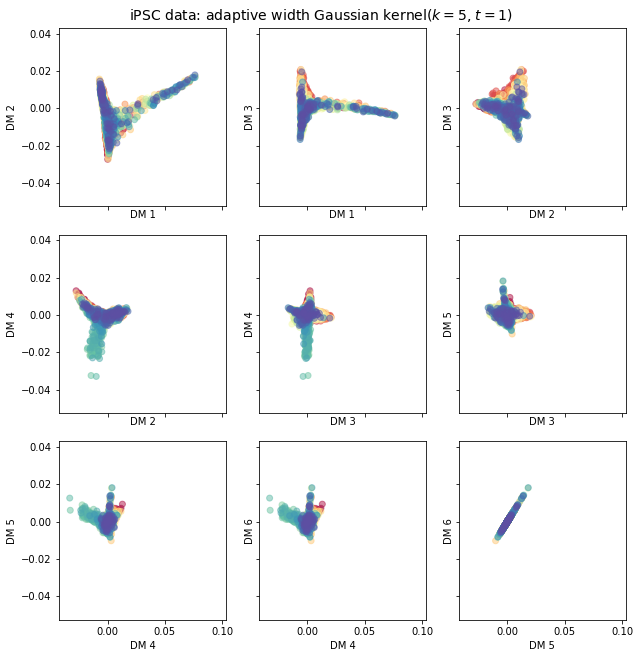

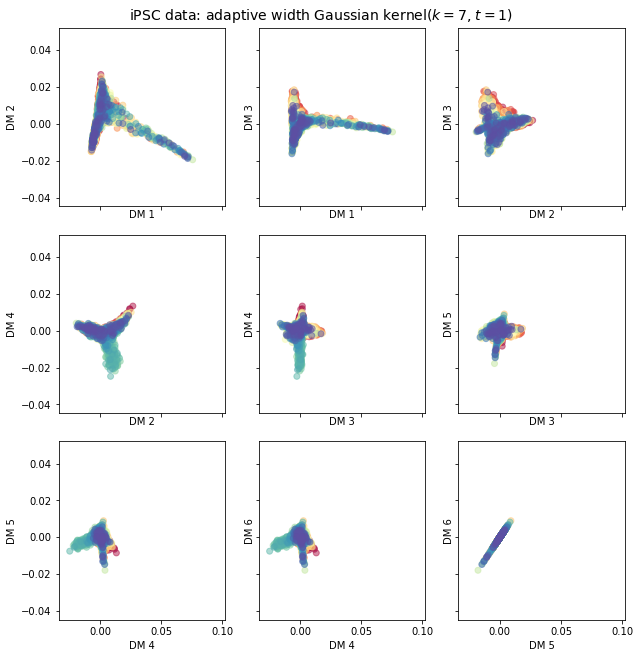

In [40]:
plot_32diff_maps(ipsc_k5_dmap, title='iPSC data: adaptive width Gaussian kernel($k=5$, $t=1$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral,)
plot_32diff_maps(ipsc_k7_dmap, title='iPSC data: adaptive width Gaussian kernel($k=7$, $t=1$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral,)

In [41]:
ipsc_k2_t2_dmap = get_diff_map(ipsc_k2_vects, ipsc_k2_vals, t=2)
ipsc_k2_t3_dmap = get_diff_map(ipsc_k2_vects, ipsc_k2_vals, t=3)
ipsc_k5_t2_dmap = get_diff_map(ipsc_k5_vects, ipsc_k5_vals, t=2)
ipsc_k5_t3_dmap = get_diff_map(ipsc_k5_vects, ipsc_k5_vals, t=3)
ipsc_k7_t2_dmap = get_diff_map(ipsc_k7_vects, ipsc_k7_vals, t=2)
ipsc_k7_t3_dmap = get_diff_map(ipsc_k7_vects, ipsc_k7_vals, t=3)

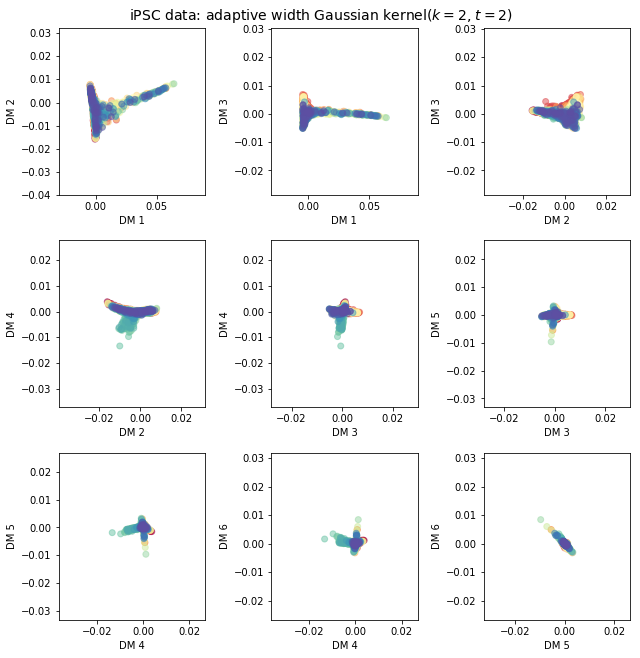

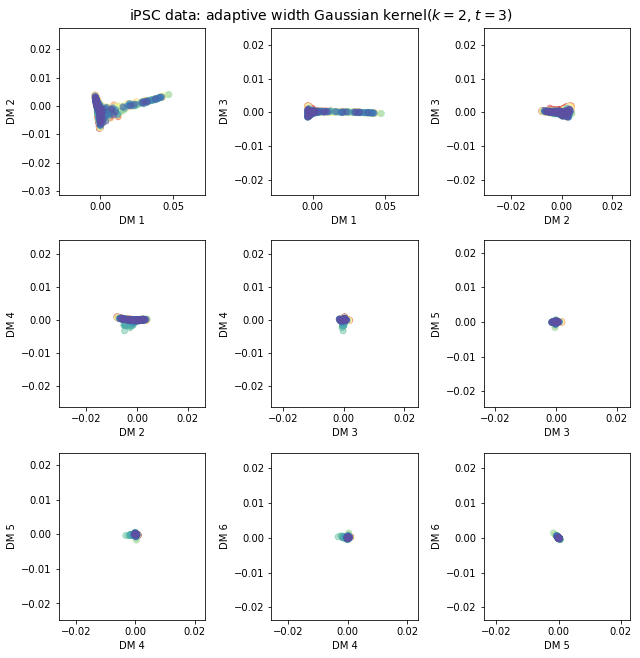

In [42]:
plot_32diff_maps(ipsc_k2_t2_dmap, title='iPSC data: adaptive width Gaussian kernel($k=2$, $t=2$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)
plot_32diff_maps(ipsc_k2_t3_dmap, title='iPSC data: adaptive width Gaussian kernel($k=2$, $t=3$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)

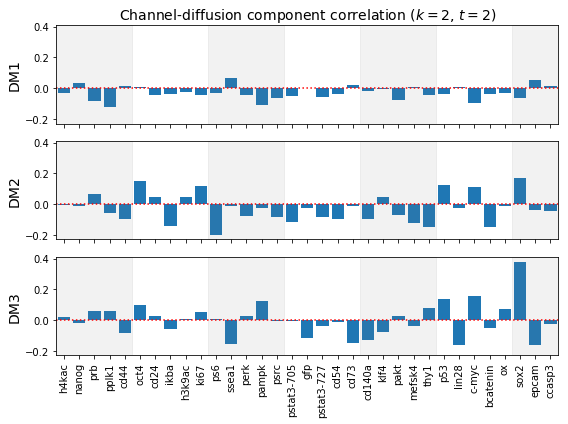

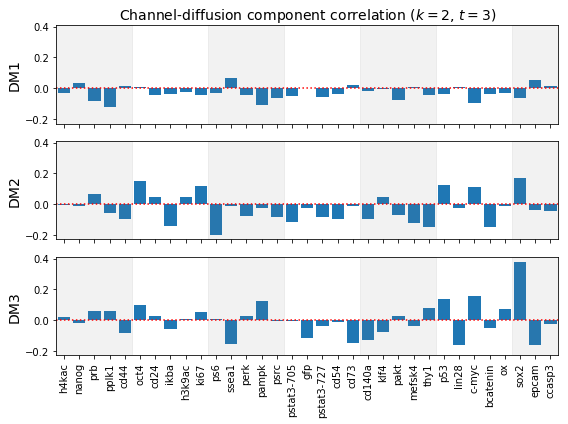

In [43]:
diff_corr_plot(ipsc_k2_t2_dmap, title='Channel-diffusion component correlation ($k=2$, $t=2$)')
diff_corr_plot(ipsc_k2_t3_dmap, title='Channel-diffusion component correlation ($k=2$, $t=3$)')

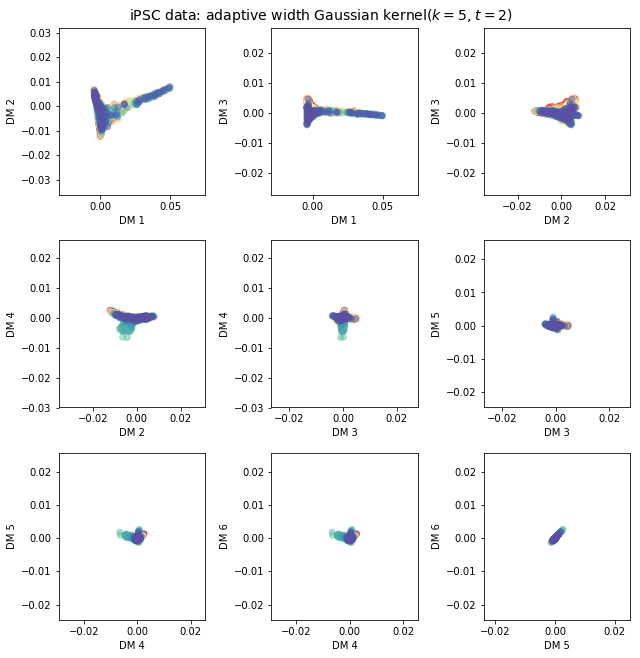

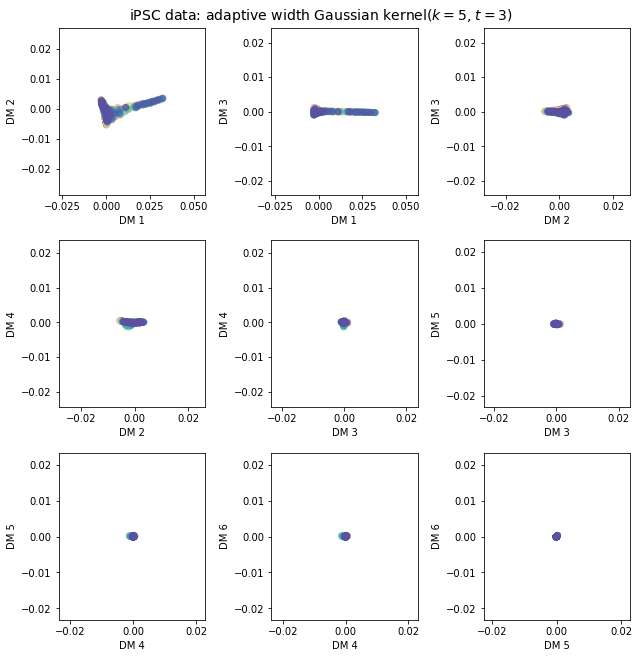

In [44]:
plot_32diff_maps(ipsc_k5_t2_dmap, title='iPSC data: adaptive width Gaussian kernel($k=5$, $t=2$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)
plot_32diff_maps(ipsc_k5_t3_dmap, title='iPSC data: adaptive width Gaussian kernel($k=5$, $t=3$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)

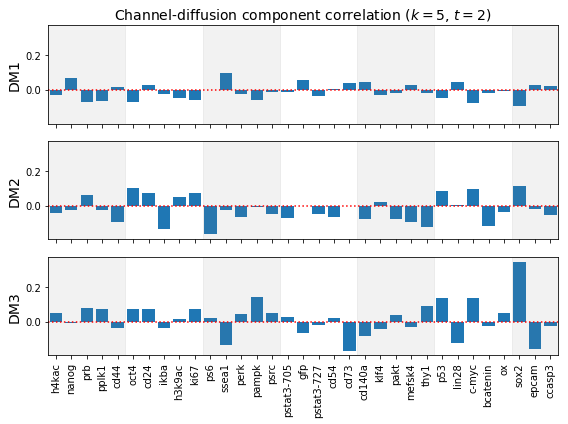

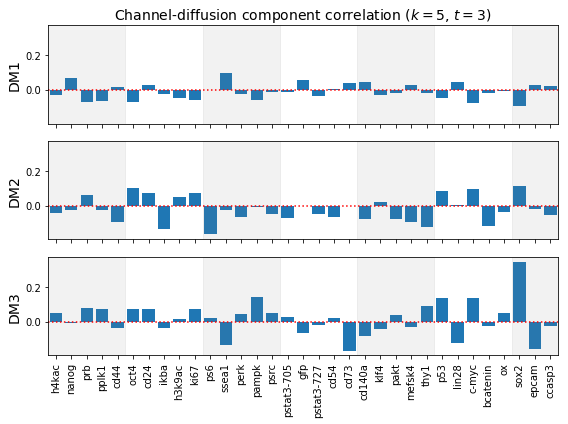

In [45]:
diff_corr_plot(ipsc_k5_t2_dmap, title='Channel-diffusion component correlation ($k=5$, $t=2$)')
diff_corr_plot(ipsc_k5_t3_dmap, title='Channel-diffusion component correlation ($k=5$, $t=3$)')

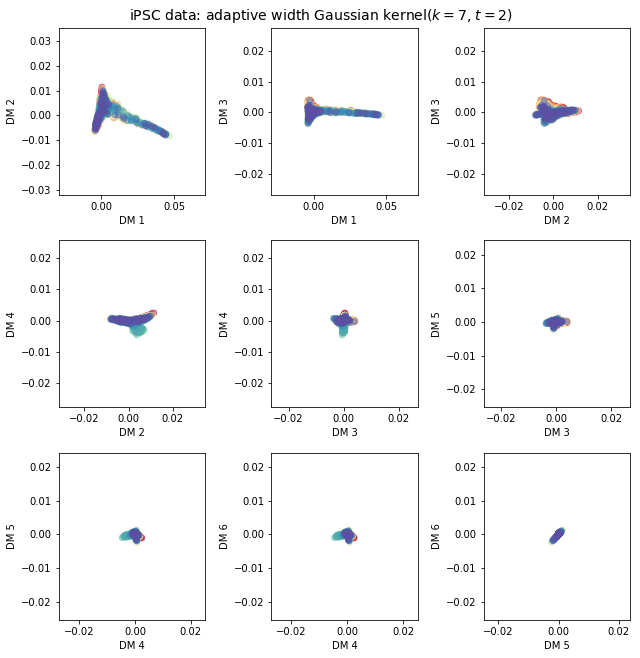

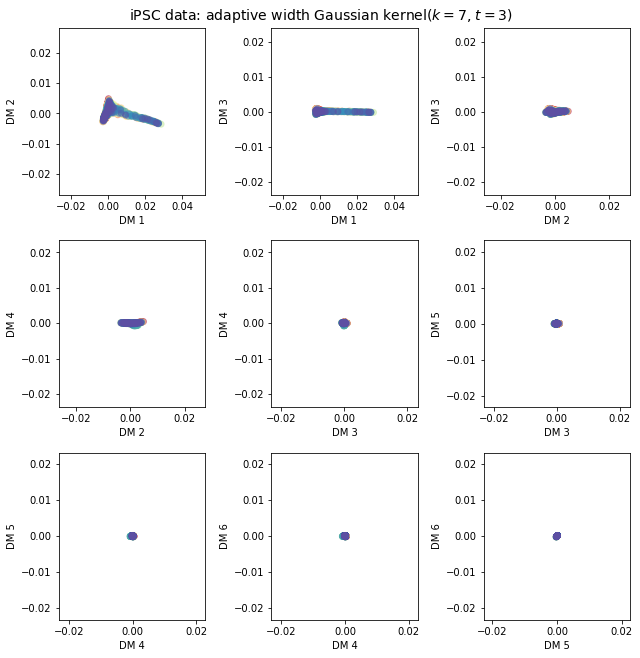

In [46]:
plot_32diff_maps(ipsc_k7_t2_dmap, title='iPSC data: adaptive width Gaussian kernel($k=7$, $t=2$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)
plot_32diff_maps(ipsc_k7_t3_dmap, title='iPSC data: adaptive width Gaussian kernel($k=7$, $t=3$)',\
                 colors=range(1,2006), cmap=matplotlib.cm.Spectral, sharex=False, sharey=False)

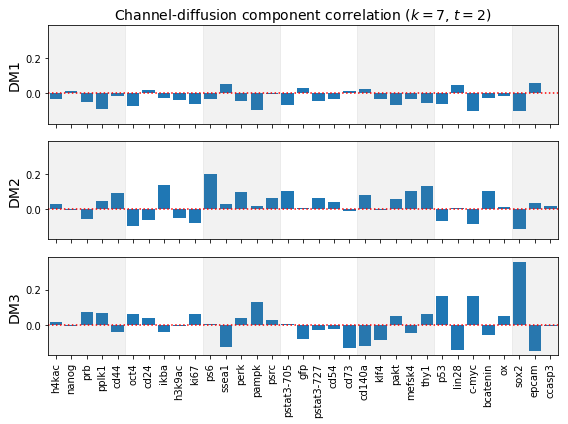

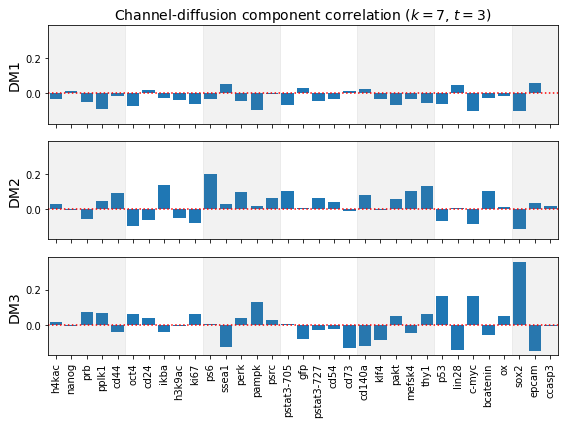

In [47]:
diff_corr_plot(ipsc_k7_t2_dmap, title='Channel-diffusion component correlation ($k=7$, $t=2$)')
diff_corr_plot(ipsc_k7_t3_dmap, title='Channel-diffusion component correlation ($k=7$, $t=3$)')

**Question 10.** Did the choice of $t$ affect the embeddings and, if so, how? Do the corresponding eigenvalues support your findings? How did the choice of $k$ affect the embeddings and, if so, how? Did previously observed trends (i.e. clusters, time progression) in diffusion dimensions change dramatically? Did the correlated channels change with $\sigma$? How would you interpret this in terms of the data?

I tried combinations of $k\in\{5,7,10\}$ and $t\in\{2,3,5,10,20,50\}$ but have only presented $k\in\{5,7\}$ and $t\in\{2,3\}$ because they produced the most informative embeddings. The choice of $t$ and $k$ had similar effects, both reducing the spread of the data in new embeddings. As before, $t$ had the effect of dramatically collapsing the points, until many embeddings were reduced to a "single" blurry point. Clustering was less evident as $k$ and time progressed, as demonstrated with the swiss roll data. 

Interestingly, the highest correlated channels from the original analysis (e.g. _sox2_, _c-myc_, _ps6_) remained highly correlated through most combinations of $k$ and $t$. This, coupled with the gene ontology information, strengthens evidence that these genes are integral in the differentiation of induced pluripotent stem cells. A number of other channels were highly correlated with the diffusion components such as _cd73_, _p53_, and _ikba_. Of these, _p53_ has functions that may be related to iPSC differentiation because its crucial role regulating many gene families and therefore many aspects of the cell cycle. 

In summary, although explorations into diffusion map parameter space were not fruitful, the overall clustering resulting from the embeddings were more useful for visualization than PCA. The application of diffusion maps with fixed width kernels preserved more of the information of high dimensional space when projected onto two dimensions. However, letting these diffusion maps evolve in time did not produce more distinct clusters; in fact, the opposite effect was observed. When applying diffusion maps to the iPSC data I found few channels that were moderately correlated with the first few diffusion components, but many that were weakly correlated. Many of these channels had gene ontologies linking them to cell cycle regulation, cell differentiation, apoptosis, and stem cell markers. 

## Literature cited

1. Eli R. Zunder et al. “A Continuous Molecular Roadmap to iPSC Reprogramming through Progression Analysis of Single-Cell Mass Cytometry”. In: _Cell stem cell_ (2015).
2. Nadler, B., Lafon, S., Coifman, R. R., & Kevrekidis, I. G. (2005). Diffusion maps, spectral clustering and eigenfunctions of Fokker-Planck operators (pp. 955–962). Presented at the Advances in Neural Information Processing Systems.
3. National Center for Biotechnology Information (NCBI)[Internet]. Bethesda (MD): National Library of Medicine (US), National Center for Biotechnology Information; [1988] – [cited 2017 Oct 01]. Available from: https://www.ncbi.nlm.nih.gov/